exponential distribution with lambda  for time between deals, uniform distribution for sizes, ranndom number of rows

In [1]:
import pandas as pd
import numpy as np
from numba import jit
from numba.core.errors import NumbaDeprecationWarning, NumbaPendingDeprecationWarning
import warnings
import math


pd.set_option('display.float_format', '{:.6f}'.format)
# Set the random seed for reproducibility (optional)
np.random.seed(42)

# Generate a random number of rows between 1000 and 1500
num_rows = np.random.randint(1000, 1500)
num_rows2 = np.random.randint(1000, 1500)

# Generate random timestamps following an exponential distribution
lambda_param = 0.5  # Adjust this parameter to control the time between deals
lambda_param2 = 0.6  # Adjust this parameter to control the time between deals

timestamps = np.cumsum(np.random.exponential(scale=1 / lambda_param, size=num_rows))
timestamps2 = np.cumsum(np.random.exponential(scale=1 / lambda_param2, size=num_rows2))

# Generate random deal sizes between 1 and 10,000,000
sizes = np.random.uniform(low=1, high=10000000, size=num_rows)
sizes2 = np.random.uniform(low=1, high=10000000, size=num_rows2)

# Create a DataFrame with the generated data
df = pd.DataFrame({'timestamp': timestamps, 'size': sizes})
df2 = pd.DataFrame({'timestamp': timestamps2, 'size': sizes2})

# Optional: Convert the 'timestamp' column to a datetime data type
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')
df2['timestamp'] = pd.to_datetime(df2['timestamp'], unit='s')
print(df)
print(df2)


                         timestamp           size
0    1970-01-01 00:00:06.020242861 7534279.469142
1    1970-01-01 00:00:08.653734248 7689228.052154
2    1970-01-01 00:00:10.479619356 6585405.498160
3    1970-01-01 00:00:10.818869097 7661159.561840
4    1970-01-01 00:00:11.158061681 8459214.550856
...                            ...            ...
1097 1970-01-01 00:36:20.746640527 4861305.366019
1098 1970-01-01 00:36:21.608591809 9207396.582687
1099 1970-01-01 00:36:21.727757826  400592.150448
1100 1970-01-01 00:36:28.681926259 2914609.843477
1101 1970-01-01 00:36:32.986568199 2075410.154516

[1102 rows x 2 columns]
                         timestamp           size
0    1970-01-01 00:00:04.379424256 2381467.298510
1    1970-01-01 00:00:13.179507204 9084345.610359
2    1970-01-01 00:00:13.497896699 4680691.074274
3    1970-01-01 00:00:14.338866457 4662994.663099
4    1970-01-01 00:00:16.705205583 7605756.663977
...                            ...            ...
1430 1970-01-01 00:40:07.

In [2]:
# Let's append a couple of TWAPs for the test case
# Constants
K = 20 #number of TWAPS
LOW_CLIP_NUM = 10
HIGH_CLIP_NUM = 80
LOW_CLIP_SIZE = 1.0 #only half of the clip
HIGH_CLIP_SIZE = 5000000.0 #only half of the clip
LOW_NOISE = -0.0001 / (24*60*60)  # Converted to days as pandas Timestamps are in days
HIGH_NOISE = 0.0001 / (24*60*60)  # Converted to days
LOW_TWAP_WINDOW = 1.0 / (24*60*60)  # Converted to days
HIGH_HIGH_TWAP_WINDOW = 800.0 / (24*60*60)  # Converted to days

# Initialize lists to hold the new data
new_timestamps1 = []
new_sizes1 = []
new_timestamps2 = []
new_sizes2 = []

# Generate the data for K TWAPs
for _ in range(K):
    num_clips = np.random.randint(LOW_CLIP_NUM, HIGH_CLIP_NUM+1)
    clip_size = np.random.uniform(LOW_CLIP_SIZE, HIGH_CLIP_SIZE)
    timestamp1 = df.sample(n=1, random_state=1)['timestamp'].values[0]
    window_twap = pd.to_timedelta(np.random.uniform(LOW_TWAP_WINDOW, HIGH_HIGH_TWAP_WINDOW), 'days')
    
    for _ in range(num_clips):
        # Generate the sizes approximately equal to the clip size in sum
        size1 = clip_size * np.random.uniform(0.0, 2.0)
        size2 = (clip_size * 2 - size1) * np.random.uniform(0.99, 1.01) 

        # Generate the timestamps
        timestamp1 += window_twap
        timestamp1 += pd.to_timedelta(np.random.uniform(LOW_NOISE, HIGH_NOISE), 'days')
        timestamp2 = timestamp1 + pd.to_timedelta(np.random.uniform(LOW_NOISE, HIGH_NOISE), 'days')

        # Append to the lists
        new_timestamps1.append(timestamp1)
        new_sizes1.append(size1)
        new_timestamps2.append(timestamp2)
        new_sizes2.append(size2)

# Create new dataframes and append to the original dataframes
new_df1 = pd.DataFrame({'timestamp': new_timestamps1, 'size': new_sizes1})
new_df2 = pd.DataFrame({'timestamp': new_timestamps2, 'size': new_sizes2})

df = pd.concat([df, new_df1], ignore_index=True)
df2 = pd.concat([df2, new_df2], ignore_index=True)

# Sort by timestamp
df = df.sort_values('timestamp').reset_index(drop=True)
df2 = df2.sort_values('timestamp').reset_index(drop=True)

print(df)
print(df2)


                         timestamp           size
0    1970-01-01 00:00:06.020242861 7534279.469142
1    1970-01-01 00:00:08.653734248 7689228.052154
2    1970-01-01 00:00:10.479619356 6585405.498160
3    1970-01-01 00:00:10.818869097 7661159.561840
4    1970-01-01 00:00:11.158061681 8459214.550856
...                            ...            ...
2008 1970-01-01 15:35:14.830148269   40128.809160
2009 1970-01-01 15:47:30.942186887 3683676.034994
2010 1970-01-01 15:59:47.054248686 3151172.946449
2011 1970-01-01 16:12:03.166296100  937491.561291
2012 1970-01-01 16:24:19.278240448  626703.925559

[2013 rows x 2 columns]
                         timestamp           size
0    1970-01-01 00:00:04.379424256 2381467.298510
1    1970-01-01 00:00:13.179507204 9084345.610359
2    1970-01-01 00:00:13.497896699 4680691.074274
3    1970-01-01 00:00:14.338866457 4662994.663099
4    1970-01-01 00:00:16.705205583 7605756.663977
...                            ...            ...
2341 1970-01-01 15:35:14.

In [3]:
# Merge the DataFrames based on the exact timestamp match
merged_df = pd.merge(df, df2, on='timestamp', how='outer')

# Calculate the sum of the 'size' columns when there is a match
merged_df['sum'] = merged_df['size_x'].fillna(0) + merged_df['size_y'].fillna(0)

# Remove unnecessary columns
merged_df = merged_df.drop(['size_x', 'size_y'], axis=1)

# Print the merged DataFrame
print(merged_df)


                         timestamp            sum
0    1970-01-01 00:00:06.020242861 7534279.469142
1    1970-01-01 00:00:08.653734248 7689228.052154
2    1970-01-01 00:00:10.479619356 6585405.498160
3    1970-01-01 00:00:10.818869097 7661159.561840
4    1970-01-01 00:00:11.158061681 8459214.550856
...                            ...            ...
4354 1970-01-01 15:35:14.830202562 3952040.674253
4355 1970-01-01 15:47:30.942097351  344010.684298
4356 1970-01-01 15:59:47.054250379  880131.966754
4357 1970-01-01 16:12:03.166392254 3109099.201361
4358 1970-01-01 16:24:19.278298958 3379913.912274

[4359 rows x 2 columns]


if the time between  rows is less than parameter (let's say 0.03ms) then delete two rows and create one with the weighted by size time that and in  sum column it will be sum of these two rows - then proceed to the further rows using the previous row as usual (it might be merged again with the next if satisfies condition) 

In [4]:
@jit(nopython=True)
def merge_rows(time, size, time_threshold_sec):
    i = 0
    merged_time = []
    merged_size = []
    while i < len(time) - 1:
        time_diff = time[i+1] - time[i]
        if time_diff <= time_threshold_sec:
            total_size = size[i] + size[i+1]
            weighted_time = ((time[i] * size[i]) + (time[i+1] * size[i+1])) / total_size
            merged_time.append(weighted_time)
            merged_size.append(total_size)
            i += 2
        else:
            merged_time.append(time[i])
            merged_size.append(size[i])
            i += 1
    if i == len(time) - 1:
        merged_time.append(time[i])
        merged_size.append(size[i])
        
    return np.array(merged_time), np.array(merged_size)

# Convert DataFrame to Numpy arrays
time = merged_df['timestamp'].values.astype(float)
size = merged_df['sum'].values
time_threshold_sec = 0.02
merged_time, merged_size = merge_rows(time, size, time_threshold_sec)

# Convert the result back to DataFrame
df_merged = pd.DataFrame({'timestamp': pd.to_datetime(merged_time), 'sum': merged_size})

tolerance = 0.00001
if abs(merged_df["sum"].sum() - df_merged["sum"].sum()) > tolerance:
    raise AssertionError("Sums are not approximately equal.")
df_merged

,timestamp,sum
0,1970-01-01 00:00:06.020242861,7534279.469142
1,1970-01-01 00:00:08.653734248,7689228.052154
2,1970-01-01 00:00:10.479619356,6585405.498160
3,1970-01-01 00:00:10.818869097,7661159.561840
4,1970-01-01 00:00:11.158061681,8459214.550856
...,...,...
4353,1970-01-01 15:35:14.830202562,3952040.674253
4354,1970-01-01 15:47:30.942097351,344010.684298
4355,1970-01-01 15:59:47.054250379,880131.966754
4356,1970-01-01 16:12:03.166392254,3109099.201361


In [5]:
N = 5  # Number of parts
# The qcut() function discretizes the variable into equal-sized buckets based on rank or 
# based on sample quantiles.
# Create buckets based on quantiles and create a new column 'bucket'
buckets = pd.qcut(df_merged['sum'], N)
print(buckets.cat.categories.values)

df_merged['bucket'] = pd.qcut(df_merged['sum'], N, labels=False)

# List to hold dataframes
df_list = []

for i in range(N):
    df_part = df_merged[df_merged['bucket'] == i]
    df_list.append(df_part.drop(['bucket', 'sum'], axis=1).reset_index(drop=True))
df_list[0]

<IntervalArray>
[(117.347, 701654.853], (701654.853, 2326839.543], (2326839.543, 4154682.572], (4154682.572, 6840950.873], (6840950.873, 9995577.033]]
Length: 5, dtype: interval[float64, right]


,timestamp
0,1970-01-01 00:00:30.222438031
1,1970-01-01 00:00:43.629815007
2,1970-01-01 00:01:58.851253341
3,1970-01-01 00:02:03.960830994
4,1970-01-01 00:02:12.784075411
...,...
867,1970-01-01 11:54:24.814494234
868,1970-01-01 11:59:06.130156424
869,1970-01-01 12:55:45.374339939
870,1970-01-01 14:09:22.046276060


In [6]:
from collections import defaultdict
import bisect

def binary_search(array, target):
    # Find the index where target should be inserted to keep the array sorted
    idx = bisect.bisect_left(array, target)
    
    if idx == 0:
        return 0
    if idx == len(array):
        return idx - 1

    before = array[idx - 1]
    after = array[idx]

    # Check which value is closer to the target
    if after - target < target - before:
       return idx
    else:
       return idx - 1


# Define the time window in minutes
T = 30
# Initialize an empty dictionary to hold dataframes

epsilon = 0.5
hashmaps = []
for df in df_list:
    hashmap = defaultdict(pd.DataFrame)
    # Iterate over the dataframe
    for i in range(len(df)):
        # Get the timestamp of the current row
        timestamp_i = df.loc[i, 'timestamp']

        # Initialize lists to hold column data
        time_distance = []
        ID = []
        TWAP = []

        # Iterate backwards over the dataframe from the current row within the time window
        j = i - 1
        while j >= 0 and (timestamp_i - df.loc[j, 'timestamp']).total_seconds() <= T*60:
            # Calculate the time difference
            time_diff = (timestamp_i - df.loc[j, 'timestamp']).total_seconds()

            # Add the calculated data to the lists
            time_distance.append(time_diff)
            ID.append(j)

            df_j = hashmap[j]
            if not df_j.empty:
                idx = binary_search(df_j['time_distance'].tolist(), time_diff)
                closest_diff = df_j.iloc[idx]['time_distance']
                if abs(closest_diff - time_diff) < epsilon:
                    TWAP.append(int(df_j.iloc[idx]['TWAP'] + 1))
                else:
                    TWAP.append(int(0))
            else:
                TWAP.append(int(0))

            j -= 1

        # Create a new dataframe from the lists and add it to the hashmap
        df_i = pd.DataFrame({'time_distance': time_distance, 'ID': ID, 'TWAP': TWAP})
        hashmap[i] = df_i
    hashmaps.append(hashmap.copy()) 

In [7]:
hashmaps

[defaultdict(pandas.core.frame.DataFrame,
             {0: Empty DataFrame
              Columns: [time_distance, ID, TWAP]
              Index: [],
              1:    time_distance  ID  TWAP
              0      13.407376   0     0,
              2:    time_distance  ID  TWAP
              0      75.221438   1     0
              1      88.628815   0     0,
              3:    time_distance  ID  TWAP
              0       5.109577   2     0
              1      80.331015   1     0
              2      93.738392   0     0,
              4:    time_distance  ID  TWAP
              0       8.823244   3     0
              1      13.932822   2     0
              2      89.154260   1     0
              3     102.561637   0     0,
              5:    time_distance  ID  TWAP
              0       3.413121   4     0
              1      12.236365   3     0
              2      17.345943   2     0
              3      92.567381   1     0
              4     105.974758   0     0,
           

In [8]:
counter_twap = [[], [], [], [], []]
for j in range(N):
    for i in range(len(hashmaps[j])):
        counter_twap[j].append(len(hashmaps[j][i][hashmaps[j][i]["TWAP"] >= 4]))

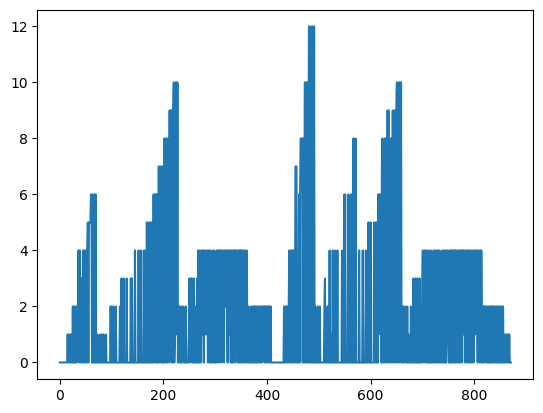

In [12]:
from matplotlib import pyplot as plt
plt.plot(counter_twap[0])
